# San Francisco Crime Analytics 2018 - 2025  
## Forecasting, Neighborhood Trends, and Patrol Optimization Using Python

**Author:** Sileshi Hirpa  
**Course:** DAT 301 (Exploring Data in R & Python)  
**Project:** Project 2 (Python)  
**Data Source:** San Francisco Police Department Incident Reports (DataSF)  
**Time Window:** 2018-2025   

---

# 1. City Context: San Francisco in Brief

San Francisco is a compact and geographically distinctive city located at the tip of a peninsula in Northern California. Though only 47 square miles in size, the city is framed by several major landmarks and transportation corridors that shape how people move through the region.

To the east, **Interstate 80 (I-80)** connects San Francisco to Oakland and Berkeley across the well-known **Bay Bridge**, carrying thousands of vehicles daily. On the northern edge of the city, the **Golden Gate Bridge** links San Francisco to Marin County via **U.S. Route 101 North**, standing as one of the most recognized bridges in the world. Extending south, **Highway 101 South** continues through the San Francisco Peninsula toward Silicon Valley, passing notable destinations such as the **San Francisco International Airport (SFO)**, the busiest airport in Northern California.

The screenshot below provides a simple geographic orientation for readers unfamiliar with the city and highlights the major entrances and exits:




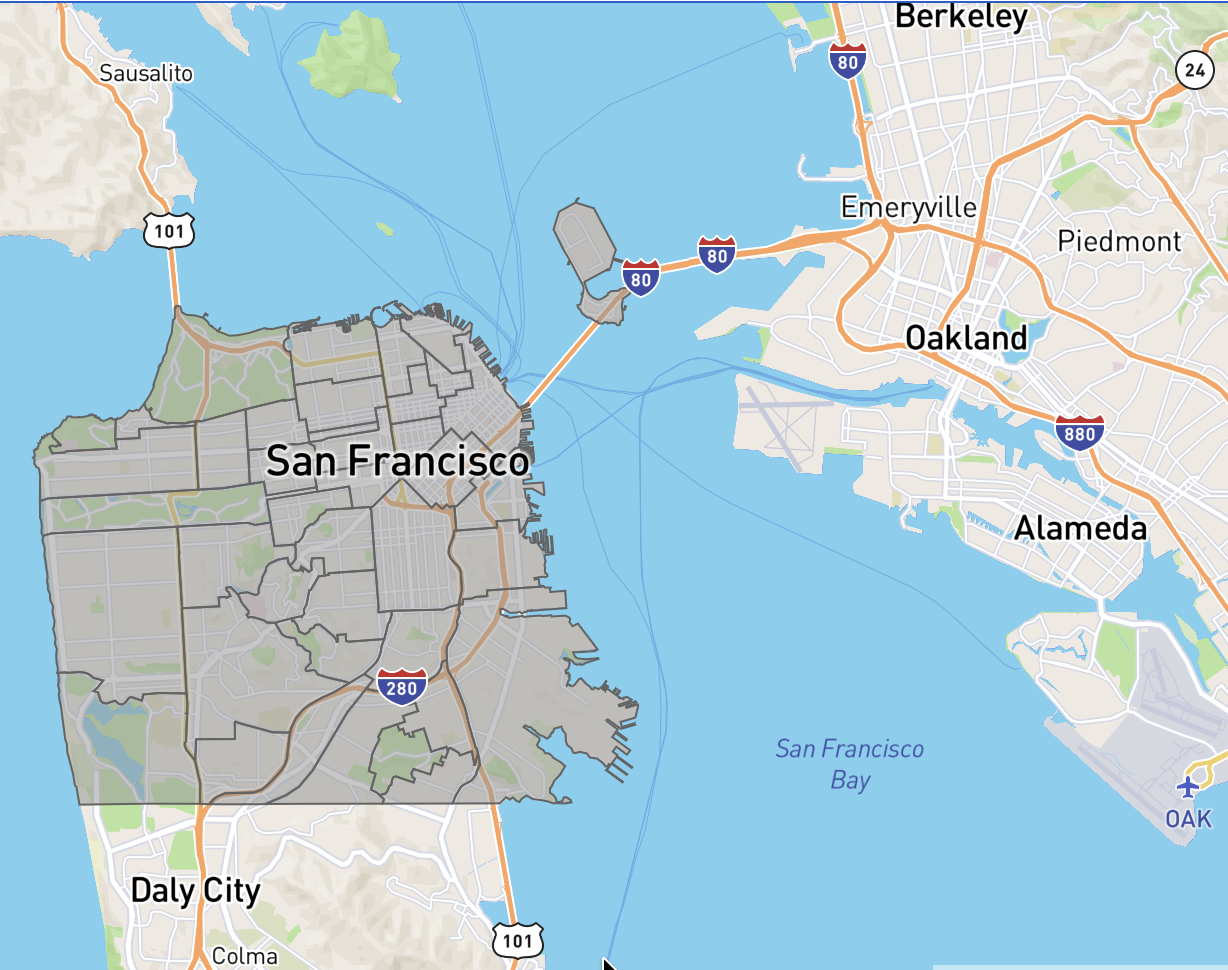

In [1]:
from IPython.display import Image
Image(filename="SF_borders.png")


# 2. Motivation for This Project

For the past several years, I have worked as an Uber driver in the San Francisco Bay Area. Many passengers - mostly visitors alike - frequently ask similar questions:

- “Which neighborhoods are safe to stay in?”  
- “Are there areas we should avoid late at night?”  
- “Which areas do you recommend for best experience?”  

I also meet many visitors who are excited about finding good hotel deals online, but later realize they did not have enough information about where those hotels are located or how the surrounding neighborhoods differ. That lack of context can lead to confusion or discomfort, especially when people arrive late at night near areas such as the Tenderloin or parts of SoMa. On several occasions, riders have even mentioned changing their hotel reservations after arriving in the city because the neighborhood they originally booked did not feel as pleasant or welcoming as they expected.

This project uses open data from the San Francisco Police Department to explore the following questions:

1. **Where** are incidents most concentrated across neighborhoods?  
2. **When** do incidents peak across hours and days of the week?  
3. **How** have incident levels changed from 2018 through 2025?  
4. **What** short-term forecast can help visualize early 2026 trends?  

This analysis serves two purposes:  
- to inform my own understanding as someone who moves throughout the city daily  
- and to demonstrate how open-source crime data can be transformed into meaningful insights through Python, visualization, and forecasting methods.

The next sections begin the data loading, cleaning, and exploratory analysis workflow, but first the necessary libraries are loaded as follows.


In [2]:
import pandas as pd
import numpy as np

# Visualization Libraries 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import folium


# Time-Series Libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA


## 2.1 About the Dataset

The analysis in this project is based on the *Police Department Incident Reports: 2018 - November 21, 2025* dataset obtained from [DataSF](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783/data_preview), the City and County of San Francisco’s open data portal. The dataset includes all reported police incidents recorded by the San Francisco Police Department (SFPD), along with associated attributes such as the incident category, description, neighborhood, timestamp, and geographic coordinates.

This dataset is well suited for exploring crime trends across time and space because it provides:

- complete coverage of all police-reported incidents,
- detailed timestamps for hourly, daily, and monthly analysis,
- neighborhood information for spatial comparison, and
- latitude and longitude for mapping and geographic visualization.

The dataset used in this project was downloaded on November 21, 2025 and contains nearly one million incident records covering the full 2018–2025 period. The next section loads the dataset and performs initial cleaning steps to prepare it for analysis.


## 2.2 Load CSV File and Initial Cleaning

This code cell performs the following actions:

1. **Loading the dataset** and parsing the date column as a proper datetime object.
2. **Renaming key columns** so that the dataset uses clear and consistent variable names throughout the notebook.
3. **Creating** the `year` **variable** and filters the dataset to the 2018 - 2025 window.
4. **Dropping records missing geographic coordinates**, since latitude and longitude are required for neighborhood mapping and location-based analysis.

In [3]:
# ============================
# Load CSV File (updated filename)
# ============================

df = pd.read_csv(
    "Police_Department_Incident_Reports__2018_to_20251121.csv",
    parse_dates=["Incident Date"],
    low_memory=False
)

# ============================
# Standardize and align column names
# ============================

df = df.rename(columns={
    # Core fields
    "Incident Date": "date",
    "Incident Time": "time",
    "Incident Category": "category",
    "Analysis Neighborhood": "neighborhood",
    "Latitude": "latitude",
    "Longitude": "longitude",
    
    # Weekly + yearly fields (from your dataset's structure)
    "Incident Day of Week": "weekday",
    "Incident Year": "incident_year"
})

# Ensure weekday is clean text
df["weekday"] = df["weekday"].astype(str)

# Create consistent 'year' variable from parsed date column
df["year"] = df["date"].dt.year


# ============================
# Restrict the analysis window to 2018–2025
# ============================

df_original_count = len(df)
df = df[(df["year"] >= 2018) & (df["year"] <= 2025)].copy()

print(f"Original records: {df_original_count}")
print(f"Records after 2018–2025 filter: {len(df)}")


# ============================
# Drop rows without latitude/longitude
# ============================

df.dropna(subset=["latitude", "longitude"], inplace=True)
print(f"Records after dropping missing geo-data: {len(df)}")


Original records: 984715
Records after 2018–2025 filter: 984715
Records after dropping missing geo-data: 930107


**Data Cleaning Insights**

The dataset contained 984,715 police incident records, representing all reported incidents in San Francisco from 2018 to 2025. After applying the year filter specified in the project scope, the record count did not change, indicating that the exported dataset already falls entirely within the intended time window.

Next, rows missing usable geographic coordinates were removed. This step is necessary for reliable neighborhood analysis and mapping. After dropping these cases, the dataset decreased to 930,107 records, meaning that about 5.5% of incidents lacked latitude or longitude information. This level of missing geolocation is typical in SFPD open data. The remaining dataset is still large and well-suited for both spatial and temporal analysis.

## 2.3 Derived Variables

To support the exploratory analysis and time-series forecasting that follow, several additional variables are created in this section. These derived features help reveal patterns in how incidents vary across time.

The primary variables created are:

- **`month`**  
  A monthly timestamp derived from the incident date and used to examine long-term trends.

- **`weekday`**  
  The day of the week the incident occurred, derived from the `Incident Day of Week` column.

- **`hour`**  
  The hour of the day extracted from the incident timestamp, useful for analyzing daily activity cycles.

These features allow the analysis to capture patterns across multiple time scales - hourly, daily, weekly, and monthly - and make it possible to build meaningful visualizations and forecasts.

## 2.4 Diagnostic Checks and Summary Statistics



In [4]:
# ============================
# A. Preview the dataset
# ============================

print("==== First five rows to verify successful loading and column structure ====\n")
display(df.head())

print("\n==== Last five rows to ensure there are no structural issues at the bottom of the file ====\n")
display(df.tail())



==== First five rows to verify successful loading and column structure ====



,Row ID,Incident Datetime,date,time,incident_year,weekday,Report Datetime,Incident ID,Incident Number,CAD Number,...,Police District,neighborhood,Supervisor District,Supervisor District 2012,latitude,longitude,Point,data_as_of,data_loaded_at,year
1,150754906372,2025/06/24 07:00:00 AM,2025-06-24,07:00,2025,Tuesday,2025/08/26 01:42:00 PM,1507549,256091528,NaN,...,Mission,Castro/Upper Market,8.0,8.0,37.757854,-122.439072,POINT (-122.439071655 37.757854462),2025/08/28 09:38:07 AM,2025/08/29 09:53:03 AM,2025
2,150764207041,2025/08/27 11:50:00 AM,2025-08-27,11:50,2025,Wednesday,2025/08/27 12:00:00 PM,1507642,250471520,252391455.0,...,Ingleside,Bernal Heights,9.0,9.0,37.746475,-122.405212,POINT (-122.405212402 37.74647522),2025/08/28 09:38:07 AM,2025/08/29 09:53:03 AM,2025
3,150758572000,2025/08/24 04:15:00 PM,2025-08-24,16:15,2025,Sunday,2025/08/27 09:35:00 AM,1507585,250480452,252391197.0,...,Ingleside,Excelsior,11.0,11.0,37.716461,-122.441017,POINT (-122.441017151 37.716461182),2025/08/28 09:38:07 AM,2025/08/29 09:53:03 AM,2025
4,150774075000,2025/08/27 05:12:00 PM,2025-08-27,17:12,2025,Wednesday,2025/08/27 05:12:00 PM,1507740,250481864,252392727.0,...,Northern,Nob Hill,3.0,3.0,37.787758,-122.420113,POINT (-122.42011261 37.787757874),2025/08/28 09:38:07 AM,2025/08/29 09:53:03 AM,2025
5,150755028135,2025/08/07 04:16:00 PM,2025-08-07,16:16,2025,Thursday,2025/08/22 09:25:00 AM,1507550,256091443,NaN,...,Mission,Castro/Upper Market,8.0,8.0,37.766014,-122.430824,POINT (-122.43082428 37.766014099),2025/08/28 09:38:07 AM,2025/08/29 09:53:03 AM,2025



==== Last five rows to ensure there are no structural issues at the bottom of the file ====



,Row ID,Incident Datetime,date,time,incident_year,weekday,Report Datetime,Incident ID,Incident Number,CAD Number,...,Police District,neighborhood,Supervisor District,Supervisor District 2012,latitude,longitude,Point,data_as_of,data_loaded_at,year
984710,150682703014,2025/08/24 02:30:00 PM,2025-08-24,14:30,2025,Sunday,2025/08/24 02:30:00 PM,1506827,250472697,252351995.0,...,Central,Chinatown,3.0,3.0,37.798443,-122.409882,POINT (-122.409881592 37.798442841),2025/08/25 09:38:33 AM,2025/08/26 09:53:45 AM,2025
984711,150688772000,2025/08/24 04:20:00 PM,2025-08-24,16:20,2025,Sunday,2025/08/24 07:56:00 PM,1506887,250475033,252362906.0,...,Southern,Financial District/South Beach,6.0,6.0,37.783607,-122.389847,POINT (-122.389846802 37.783607483),2025/08/25 09:38:33 AM,2025/08/26 09:53:45 AM,2025
984712,150680716623,2025/08/24 12:38:00 PM,2025-08-24,12:38,2025,Sunday,2025/08/24 12:38:00 PM,1506807,250474308,252361507.0,...,Tenderloin,Tenderloin,5.0,6.0,37.783516,-122.415886,POINT (-122.415885925 37.78351593),2025/08/25 09:38:33 AM,2025/08/26 09:53:45 AM,2025
984713,150667516030,2025/08/23 06:41:00 PM,2025-08-23,18:41,2025,Saturday,2025/08/23 06:41:00 PM,1506675,250473087,252352731.0,...,Mission,Mission,9.0,9.0,37.763050,-122.419479,POINT (-122.41947937 37.763050079),2025/08/25 09:38:33 AM,2025/08/26 09:53:45 AM,2025
984714,150669326120,2025/08/23 06:19:00 PM,2025-08-23,18:19,2025,Saturday,2025/08/23 06:31:00 PM,1506693,250473043,252352695.0,...,Central,Financial District/South Beach,3.0,3.0,37.798431,-122.402229,POINT (-122.402229309 37.798431396),2025/08/25 09:38:33 AM,2025/08/26 09:53:45 AM,2025


In [5]:
# ============================
# B. Summary of dataset structure
# ============================

print("==== Dataset information: data types, memory usage, and missingness overview ====\n")
df.info()


==== Dataset information: data types, memory usage, and missingness overview ====

<class 'pandas.core.frame.DataFrame'>
Index: 930107 entries, 1 to 984714
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Row ID                    930107 non-null  int64         
 1   Incident Datetime         930107 non-null  object        
 2   date                      930107 non-null  datetime64[ns]
 3   time                      930107 non-null  object        
 4   incident_year             930107 non-null  int64         
 5   weekday                   930107 non-null  object        
 6   Report Datetime           930107 non-null  object        
 7   Incident ID               930107 non-null  int64         
 8   Incident Number           930107 non-null  int64         
 9   CAD Number                759469 non-null  float64       
 10  Report Type Code          930107 non-null  object 

**Insight:**

The dataset is large, containing over 930,000 fully usable records with mostly complete fields, and although some columns have moderate missingness (such as CAD Number and Filed Online), all core variables needed for temporal and spatial analysis - date, time, category, neighborhood, and coordinates - are intact and consistently structured for reliable analysis.

In [6]:
# ============================
# C. Descriptive statistics
# ============================

print("==== Descriptive statistics for numeric columns to identify ranges and potential anomalies ====\n")
display(df.describe().T)


==== Descriptive statistics for numeric columns to identify ranges and potential anomalies ====



,count,mean,min,25%,50%,75%,max,std
Row ID,930107.0,107663534145.128403,61869104134.0,84962578642.0,107605706224.0,130492559570.5,152766806372.0,26262694976.906979
date,930107,2021-09-13 08:26:14.745271296,2018-01-01 00:00:00,2019-09-12 00:00:00,2021-09-16 00:00:00,2023-07-23 00:00:00,2025-11-20 00:00:00,NaN
incident_year,930107.0,2021.207085,2018.0,2019.0,2021.0,2023.0,2025.0,2.236757
Incident ID,930107.0,1076635.097633,618691.0,849625.5,1076057.0,1304925.5,1527668.0,262626.947247
Incident Number,930107.0,213545710.039065,0.0,190843558.0,210728167.0,230641831.0,990110341.0,22611595.007338
CAD Number,759469.0,215131568.110797,0.0,192763380.0,212800540.0,232353378.0,999999999.0,31598832.655547
Incident Code,930107.0,24381.843144,1000.0,6244.0,7053.0,28161.0,75030.0,25384.869573
CNN,930107.0,25769200.843559,20013000.0,23948000.0,24929000.0,26486000.0,54412000.0,4941432.103933
Supervisor District,929491.0,5.983888,1.0,3.0,6.0,9.0,11.0,2.805695
Supervisor District 2012,930018.0,6.025474,1.0,3.0,6.0,9.0,11.0,2.792464


**Insight:**

The numeric columns display sensible ranges and quartiles, with latitude and longitude tightly centered around San Francisco’s geographic boundaries and the year variable correctly spanning 2018–2025. No extreme outliers or structurally inconsistent values appear that would compromise the exploratory analysis or forecasting steps that follow.


In [7]:
# ============================
# D. Missing value summary
# ============================

print("==== Count of missing values in each column (sorted from highest to lowest) ====\n")
display(df.isnull().sum().sort_values(ascending=False))


==== Count of missing values in each column (sorted from highest to lowest) ====



Filed Online                772614
CAD Number                  170638
Incident Subcategory          1408
category                      1408
Supervisor District            616
neighborhood                   292
Supervisor District 2012        89
weekday                          0
Incident ID                      0
incident_year                    0
date                             0
time                             0
Row ID                           0
Incident Datetime                0
Incident Code                    0
Report Type Description          0
Report Type Code                 0
Incident Number                  0
Report Datetime                  0
Intersection                     0
Resolution                       0
Incident Description             0
Police District                  0
CNN                              0
latitude                         0
longitude                        0
Point                            0
data_as_of                       0
data_loaded_at      

**Insight:**

The dataset contains mostly complete records for all core variables needed for temporal and spatial analysis.  
A few optional administrative fields - such as `CAD Number`, `Filed Online`, and certain supervisor district fields - show moderate missingness, but these do not affect neighborhood analysis, incident classification, or time-series modeling. The essential variables (`date`, `time`, `category`, `neighborhood`, `latitude`, `longitude`) are almost fully populated, so the dataset is well suited for reliable EDA and forecasting.


In [8]:
# ============================
# Create derived "hour" column
# ============================

print("==== Creating 'hour' from Incident Datetime (most reliable source) ====\n")

# If Incident Datetime is already a datetime type, this works directly.
# If not, pandas will convert it.
df["Incident Datetime"] = pd.to_datetime(df["Incident Datetime"], errors="coerce")

# Extract hour
df["hour"] = df["Incident Datetime"].dt.hour

print("==== Done. Sample hours: ====\n")
display(df["hour"].head())


==== Creating 'hour' from Incident Datetime (most reliable source) ====

==== Done. Sample hours: ====



1     7
2    11
3    16
4    17
5    16
Name: hour, dtype: int32

**Insight:**

The hour variable was successfully extracted from the Incident Datetime column, and the sample values confirm that the timestamps convert cleanly into 24-hour numeric format. This verifies that the datetime field is well-structured and ready to support hourly trend analysis, heatmaps, and other time-of-day visualizations in the EDA.

In [9]:
# ============================
# E. Distribution of key categorical variables
# ============================

print("==== Top 10 neighborhoods by incident count ====\n")
display(df['neighborhood'].value_counts().head(10))

print("\n==== Top 10 incident categories ====\n")
display(df['category'].value_counts().head(10))

print("\n==== Incident count by weekday ====\n")
display(df['weekday'].value_counts())

print("\n==== Incident count by hour of the day (0 - 23) ====\n")
display(df['hour'].value_counts().sort_index())


==== Top 10 neighborhoods by incident count ====



neighborhood
Mission                           101396
Tenderloin                         98339
South of Market                    88102
Financial District/South Beach     63416
Bayview Hunters Point              59860
Western Addition                   32635
North Beach                        28706
Sunset/Parkside                    27773
Nob Hill                           26627
Marina                             26011
Name: count, dtype: int64


==== Top 10 incident categories ====



category
Larceny Theft          263080
Other Miscellaneous     67956
Malicious Mischief      64755
Assault                 63640
Burglary                54776
Motor Vehicle Theft     53701
Non-Criminal            36497
Fraud                   32089
Warrant                 31777
Drug Offense            29469
Name: count, dtype: int64


==== Incident count by weekday ====



weekday
Friday       142217
Wednesday    139603
Thursday     133939
Tuesday      132067
Monday       131133
Saturday     129638
Sunday       121510
Name: count, dtype: int64


==== Incident count by hour of the day (0 - 23) ====



hour
0     54352
1     25299
2     22190
3     18222
4     15610
5     13821
6     16196
7     22393
8     33940
9     37145
10    42581
11    46053
12    62623
13    48772
14    48282
15    51581
16    53209
17    55794
18    55097
19    49120
20    44879
21    40530
22    38533
23    33885
Name: count, dtype: int64

### Insights:

**1. Neighborhood Distribution**

The highest incident volumes are concentrated in Mission, Tenderloin, and South of Market - three dense neighborhoods with heavy foot traffic, nightlife, commercial activity, and transit connections. These areas traditionally account for a large share of police calls, and the counts in this dataset follow that well-known pattern.

**2. Incident Category Distribution**

Larceny Theft is by far the dominant category, reflecting the long-standing pattern of property crime in San Francisco. Categories such as Malicious Mischief, Assault, Burglary, and Motor Vehicle Theft also appear frequently, forming the core group of incidents that drive citywide totals year after year.

**3. Weekday Distribution**

Incidents are relatively evenly spread across the week but peak slightly on Fridays, which often see higher mobility, nightlife, and social activity. Sundays show the lowest volume, consistent with quieter movement patterns across the city.

**4. Hour-of-Day Distribution**

The hourly pattern has two clear peaks: one at midnight and another around midday. Early morning hours (roughly 2 AM–5 AM) are the quietest, while daytime and early evening hours show steady, high activity. This pattern is typical of large cities where property crime and public disturbances follow both business hours and nightlife cycles.

### Note on Neighborhood Naming

The neighborhood labels in the dataset follow the official 41-zone “Analysis Neighborhoods” system used by DataSF. This system is employed by the San Francisco Police Department, the Department of Public Health, and the Mayor’s Office to ensure consistent reporting across city agencies. Because these 41 analysis zones combine or redefine several commonly known neighborhoods, their names may differ from those used by the San Francisco Planning Department or from informal neighborhood boundaries found on maps, tourism guides, or Wikipedia. For example, the area labeled “Financial District/South Beach” in the [Analysis Neighborhood](https://data.sfgov.org/-/Analysis-Neighborhoods/p5b7-5n3h) system would appear as two separate neighborhoods in other sources. For the purposes of this project, all EDA and visualizations use the official SFPD Analysis Neighborhood definitions to maintain accuracy and consistency with city-level reporting.

## Approximate Mapping: Common Neighborhood Names vs. Analysis Neighborhoods

The table below gives a practical translation from the 41 Analysis Neighborhoods
to the closest common or informal neighborhood names people use in daily life.
These are approximate matches meant to help interpretation.

| Analysis Neighborhood (DataSF) | Closest Common Name(s) |
|---|---|
| Bayview Hunters Point | Bayview, Hunters Point, Butchertown |
| Bernal Heights | Bernal Heights |
| Castro/Upper Market | The Castro, Upper Market, Duboce Triangle |
| Chinatown | Chinatown |
| Excelsior | Excelsior, Mission Terrace (parts) |
| Financial District/South Beach | Financial District, South Beach, Embarcadero (downtown portion) |
| Glen Park | Glen Park |
| Golden Gate Park | Golden Gate Park |
| Haight Ashbury | Haight-Ashbury, Cole Valley (parts), Buena Vista area |
| Hayes Valley | Hayes Valley, Civic Center fringe (west) |
| Inner Richmond | Inner Richmond, Central Richmond |
| Inner Sunset | Inner Sunset |
| Japantown | Japantown, Western Addition (northeast portion) |
| Lakeshore | Lakeshore, Lake Merced area, St. Francis Wood fringe |
| Lincoln Park | Lincoln Park, Sea Cliff fringe |
| Lone Mountain/USF | USF area, Lone Mountain, Inner Anza Vista fringe |
| Marina | Marina, Cow Hollow (often grouped informally) |
| McLaren Park | McLaren Park, University Mound fringe |
| Mission | Mission District |
| Mission Bay | Mission Bay, China Basin |
| Nob Hill | Nob Hill, Lower Nob Hill |
| Noe Valley | Noe Valley |
| North Beach | North Beach, Telegraph Hill |
| Oceanview/Merced/Ingleside | Oceanview, Ingleside, Merced Heights, Lakeview |
| Outer Mission | Outer Mission, Crocker-Amazon, Geneva area |
| Outer Richmond | Outer Richmond |
| Pacific Heights | Pacific Heights, Lower Pacific Heights |
| Portola | Portola, Silver Terrace fringe |
| Potrero Hill | Potrero Hill, Dogpatch fringe |
| Presidio | Presidio |
| Presidio Heights | Presidio Heights, Laurel Heights fringe |
| Russian Hill | Russian Hill |
| Seacliff | Sea Cliff |
| South of Market | SoMa (South of Market) |
| Sunset/Parkside | Inner Sunset fringe, Outer Sunset, Parkside |
| Tenderloin | Tenderloin |
| Treasure Island | Treasure Island, Yerba Buena Island |
| Twin Peaks | Twin Peaks, Clarendon Heights |
| Visitacion Valley | Visitacion Valley |
| West Of Twin Peaks | West Portal, Forest Hill, St. Francis Wood (parts) |
| Western Addition | Western Addition, Alamo Square, Fillmore, Lower Haight fringe |


Note: “Common names” are informal guideposts. The analysis uses the official 41-zone system.

==== Spatial density (hexbin) of incidents ====



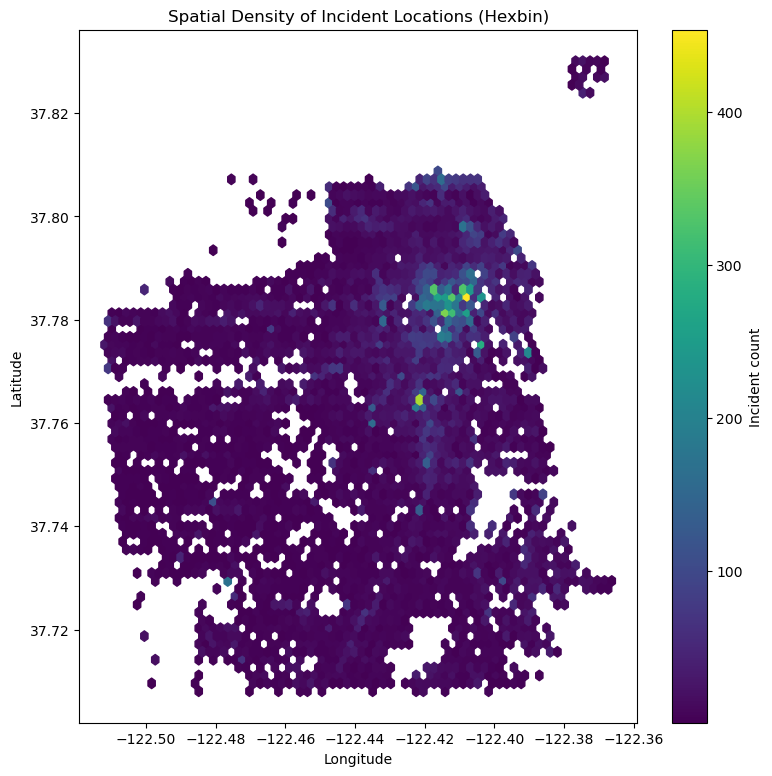

In [10]:
print("==== Spatial density (hexbin) of incidents ====\n")

df_sample = df.dropna(subset=["latitude", "longitude"]).sample(50000, random_state=42)

plt.figure(figsize=(9, 9))
plt.hexbin(df_sample["longitude"], df_sample["latitude"], gridsize=70, mincnt=1)
plt.title("Spatial Density of Incident Locations (Hexbin)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Incident count")
plt.show()


In [11]:
# ============================
# Download clean Analysis Neighborhoods GeoJSON (GitHub mirror)
# ============================

print("==== Downloading CLEAN Analysis Neighborhoods GeoJSON (mirror) ====\n")

import requests, json

mirror_url = (
    "https://raw.githubusercontent.com/sfchronicle/sf-shapefiles/main/"
    "SF%20neighborhoods/sf-neighborhoods-analysis.json"
)

r = requests.get(mirror_url)
r.raise_for_status()

geojson_clean = r.json()

out_path = "Analysis_Neighborhoods_CLEAN.geojson"
with open(out_path, "w") as f:
    json.dump(geojson_clean, f)

print("Saved clean file as:", out_path)
print("Number of features (zones):", len(geojson_clean["features"]))


==== Downloading CLEAN Analysis Neighborhoods GeoJSON (mirror) ====

Saved clean file as: Analysis_Neighborhoods_CLEAN.geojson
Number of features (zones): 41


In [12]:
import geopandas as gpd

print("==== Loading clean Analysis Neighborhood boundaries into GeoPandas (pyogrio) ====\n")

gdf_nbh = gpd.read_file("Analysis_Neighborhoods_CLEAN.geojson")

print("Loaded GeoDataFrame with rows:", len(gdf_nbh))
print("\nColumns available:\n", list(gdf_nbh.columns))

display(gdf_nbh.head())


==== Loading clean Analysis Neighborhood boundaries into GeoPandas (pyogrio) ====

Loaded GeoDataFrame with rows: 41

Columns available:
 ['nhood', 'geometry']


,nhood,geometry
0,Bayview Hunters Point,"POLYGON ((-122.40545 37.70835, -122.39317 37.7..."
1,Bernal Heights,"POLYGON ((-122.40691 37.73797, -122.40691 37.7..."
2,Castro/Upper Market,"POLYGON ((-122.42561 37.75663, -122.42575 37.7..."
3,Chinatown,"POLYGON ((-122.40204 37.79751, -122.40551 37.7..."
4,Excelsior,"POLYGON ((-122.4217 37.73181, -122.42392 37.73..."


In [13]:
import geopandas
print("GeoPandas IO engine:", geopandas.options.io_engine)


GeoPandas IO engine: None


In [14]:

print("==== Creating labeled centroid map of SF Analysis Neighborhoods (closer zoom) ====\n")

# Compute centroids from incident points
centroids = (
    df.groupby("neighborhood")[["latitude", "longitude"]]
      .median()
      .reset_index()
)

# Add incident counts for labels
counts = df["neighborhood"].value_counts().reset_index()
counts.columns = ["neighborhood", "incident_count"]

centroids = centroids.merge(counts, on="neighborhood", how="left")

# Build map centered tightly on San Francisco
m = folium.Map(
    location=[37.7749, -122.4194],   # San Francisco center
    zoom_start=14,                 # closer city view
    tiles="cartodbpositron"
)

# Add centroids and labels
for _, row in centroids.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=4,
        color="blue",
        fill=True,
        fill_opacity=0.7,
        popup=f"{row['neighborhood']}<br>Total incidents: {row['incident_count']:,}"
    ).add_to(m)

    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        icon=folium.DivIcon(
            html=f"""
            <div style="font-size:8pt; color:black; font-weight:bold;">
                {row['neighborhood']}
            </div>
            """
        )
    ).add_to(m)

m


==== Creating labeled centroid map of SF Analysis Neighborhoods (closer zoom) ====



In [15]:
#import folium

print("==== Creating full SF Analysis Neighborhood boundary map (zoomed to SF) ====\n")

# detect name column
name_candidates = [c for c in gdf_nbh.columns if "hood" in c.lower() or "neigh" in c.lower() or "name" in c.lower()]
name_field = name_candidates[0]

print("Using name field:", name_field)

m = folium.Map(location=[37.77, -122.42], zoom_start=12.5, tiles="cartodbpositron")

folium.GeoJson(
    gdf_nbh,
    name="Analysis Neighborhoods",
    style_function=lambda x: {"fillColor": "#00000000", "color": "blue", "weight": 1},
    tooltip=folium.GeoJsonTooltip(
        fields=[name_field],
        aliases=["Analysis Neighborhood:"],
        sticky=True
    )
).add_to(m)

# zoom tight to SF boundary
bounds = gdf_nbh.total_bounds
m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

folium.LayerControl().add_to(m)
m


==== Creating full SF Analysis Neighborhood boundary map (zoomed to SF) ====

Using name field: nhood


In [16]:
gpd.options.io_engine = "pyogrio"

gdf_nbh = gpd.read_file("Analysis_Neighborhoods_CLEAN.geojson")
print("Loaded", len(gdf_nbh), "zones")
gdf_nbh.head()

Loaded 41 zones


,nhood,geometry
0,Bayview Hunters Point,"POLYGON ((-122.40545 37.70835, -122.39317 37.7..."
1,Bernal Heights,"POLYGON ((-122.40691 37.73797, -122.40691 37.7..."
2,Castro/Upper Market,"POLYGON ((-122.42561 37.75663, -122.42575 37.7..."
3,Chinatown,"POLYGON ((-122.40204 37.79751, -122.40551 37.7..."
4,Excelsior,"POLYGON ((-122.4217 37.73181, -122.42392 37.73..."


In [17]:
# ============================
# Choropleth of incidents by Analysis Neighborhood (41 zones)
# ============================

print("==== Creating incident counts per Analysis Neighborhood ====\n")

# 1. Count incidents per neighborhood from your cleaned incident dataframe
nbh_counts = (
    df.groupby("neighborhood")
      .size()
      .reset_index(name="incident_count")
)

print("==== Top 10 neighborhoods by total incidents ====\n")
display(nbh_counts.sort_values("incident_count", ascending=False).head(10))

print("\n==== Joining incident counts to neighborhood boundaries ====\n")

# 2. Join counts to the polygon GeoDataFrame
gdf_joined = gdf_nbh.merge(
    nbh_counts,
    left_on="nhood",          # official zone name in boundary file
    right_on="neighborhood",  # matching name in incident file
    how="left"
)

# Any zones with no incidents become 0
gdf_joined["incident_count"] = gdf_joined["incident_count"].fillna(0)

print("Zones after join:", len(gdf_joined))
print("Missing counts filled with 0.\n")

print("==== Building Folium choropleth map ====\n")

import folium

# Base map centered on SF
m_choro = folium.Map(location=[37.77, -122.42], zoom_start=12.5, tiles="cartodbpositron")

# Choropleth layer
folium.Choropleth(
    geo_data=gdf_joined,
    data=gdf_joined,
    columns=["nhood", "incident_count"],
    key_on="feature.properties.nhood",
    fill_color="YlOrRd",   # light yellow -> dark red
    fill_opacity=0.75,
    line_opacity=0.7,
    legend_name="Total Incidents (2018–2025)",
    nan_fill_color="lightgray"
).add_to(m_choro)

# Hover tooltip
folium.GeoJson(
    gdf_joined,
    name="Neighborhood Info",
    style_function=lambda x: {"fillColor": "#00000000", "color": "black", "weight": 0.5},
    tooltip=folium.GeoJsonTooltip(
        fields=["nhood", "incident_count"],
        aliases=["Neighborhood:", "Total Incidents:"],
        sticky=True
    )
).add_to(m_choro)

folium.LayerControl().add_to(m_choro)

m_choro


==== Creating incident counts per Analysis Neighborhood ====

==== Top 10 neighborhoods by total incidents ====



,neighborhood,incident_count
18,Mission,101396
35,Tenderloin,98339
33,South of Market,88102
5,Financial District/South Beach,63416
0,Bayview Hunters Point,59860
40,Western Addition,32635
22,North Beach,28706
34,Sunset/Parkside,27773
20,Nob Hill,26627
16,Marina,26011



==== Joining incident counts to neighborhood boundaries ====

Zones after join: 41
Missing counts filled with 0.

==== Building Folium choropleth map ====



### Choropleth Insight

The choropleth shows that incidents are highly concentrated in a small set of central and northeast neighborhoods, especially Mission, Tenderloin, and South of Market, while many outer residential zones in the west and far south record substantially lower totals. This spatial imbalance highlights where patrol demand and public safety resources are most heavily pressured citywide.


### Why the 41 Analysis Neighborhood System Exists

San Francisco agencies adopted the 41 Analysis Neighborhood system to create one consistent geography for reporting citywide indicators. These zones were built by grouping Census tracts into neighborhoods that reflect how residents and planning agencies commonly describe the city. Using a single standardized set allows the Police Department, Public Health, and other departments to compare trends across time and across datasets without mismatched neighborhood definitions. 

With the standardized 41 Analysis Neighborhood geography established, we now explore how incidents vary over time, across categories, and between neighborhoods.


In [18]:
# =====================================
# Ensure 'month' column exists
# =====================================

df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()

print("Sample of month column:")
display(df[["date", "month"]].head())


Sample of month column:


,date,month
1,2025-06-24,2025-06-01
2,2025-08-27,2025-08-01
3,2025-08-24,2025-08-01
4,2025-08-27,2025-08-01
5,2025-08-07,2025-08-01


# 3. Exploratory Data Analysis (EDA)
## 3.1 Yearly Trends (2018–2025)

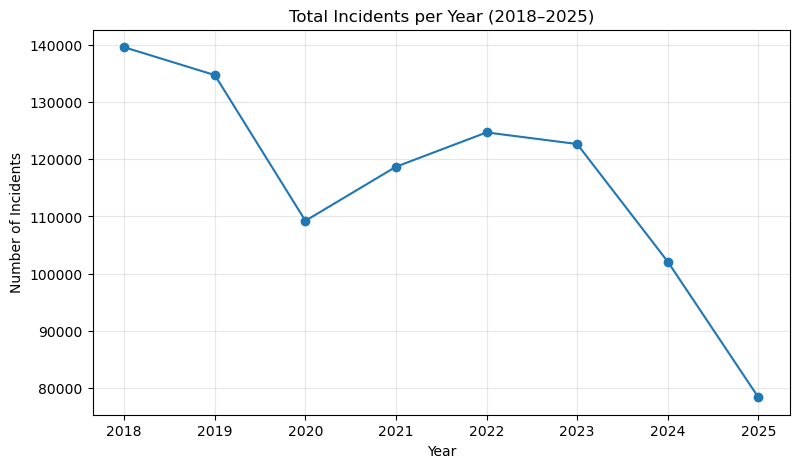

,year,incidents
0,2018,139579
1,2019,134708
2,2020,109248
3,2021,118692
4,2022,124691
5,2023,122662
6,2024,102111
7,2025,78416


In [19]:
yearly_counts = df.groupby("year").size().reset_index(name="incidents")

plt.figure(figsize=(9,5))
plt.plot(yearly_counts["year"], yearly_counts["incidents"], marker="o")
plt.title("Total Incidents per Year (2018–2025)")
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.grid(True, alpha=0.3)
plt.show()

display(yearly_counts)


## 3.2 Monthly Trend Visualization

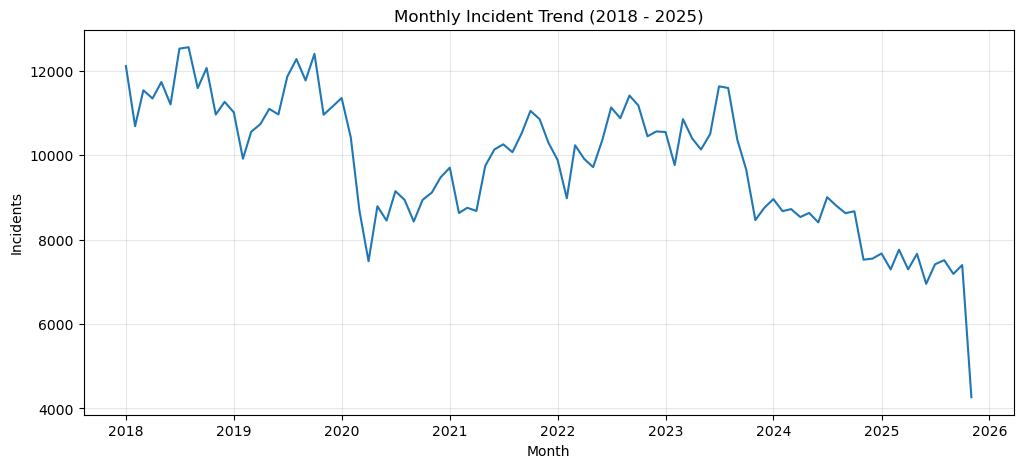

In [20]:
monthly_counts = df.groupby("month").size().reset_index(name="incidents")

plt.figure(figsize=(12,5))
plt.plot(monthly_counts["month"], monthly_counts["incidents"])
plt.title("Monthly Incident Trend (2018 - 2025)")
plt.xlabel("Month")
plt.ylabel("Incidents")
plt.grid(True, alpha=0.3)
plt.show()


## 3.3 Crime by Neighborhood

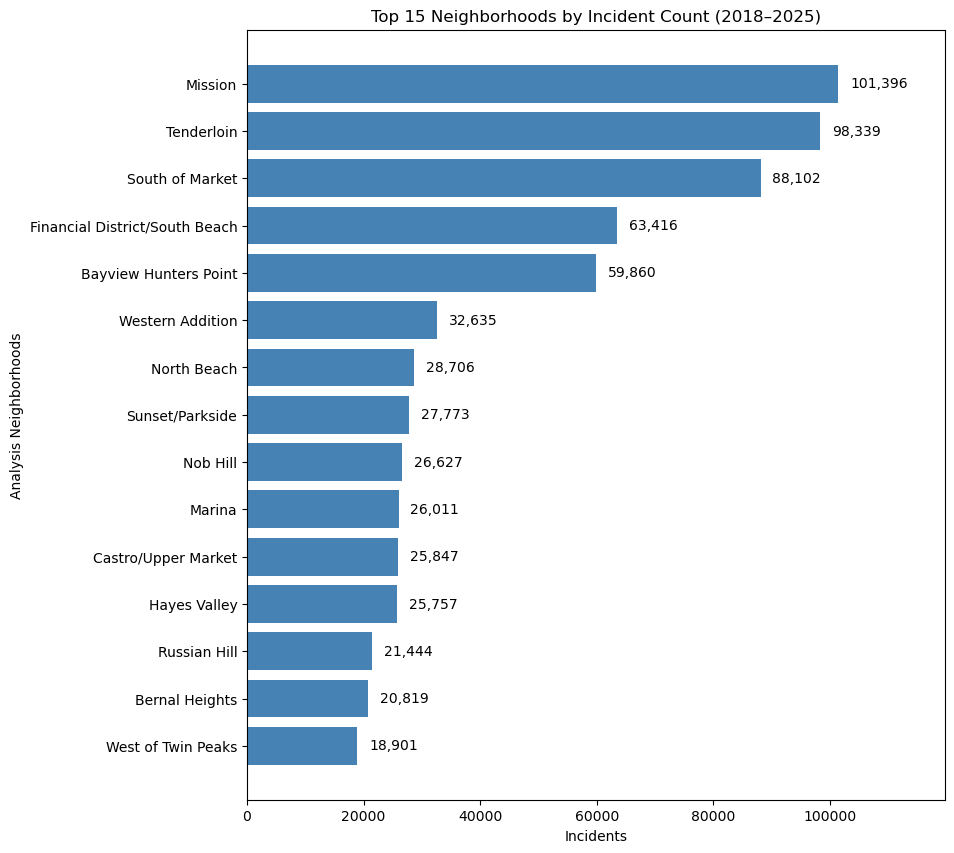

In [21]:
nbh_counts = df["neighborhood"].value_counts().reset_index()
nbh_counts.columns = ["neighborhood", "incidents"]

top15 = nbh_counts.head(15)

plt.figure(figsize=(9,10))
bars = plt.barh(top15["neighborhood"], top15["incidents"], color="steelblue")
plt.gca().invert_yaxis()
plt.title("Top 15 Neighborhoods by Incident Count (2018–2025)")
plt.xlabel("Incidents")
plt.ylabel("Analysis Neighborhoods")   # ← added label here

# ==== Dynamically expand x-limit ====
max_val = top15["incidents"].max()
plt.xlim(0, max_val * 1.18)  # expand 18%

# ==== Add labels outside each bar ====
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + max_val * 0.02,     # 2% to the right of the bar
        bar.get_y() + bar.get_height()/2,
        f"{int(width):,}",
        va="center",
        fontsize=10
    )

plt.show()


## 3.4 Category Distribution

,category,incidents
0,Larceny Theft,263080
1,Other Miscellaneous,67956
2,Malicious Mischief,64755
3,Assault,63640
4,Burglary,54776
5,Motor Vehicle Theft,53701
6,Non-Criminal,36497
7,Fraud,32089
8,Warrant,31777
9,Drug Offense,29469


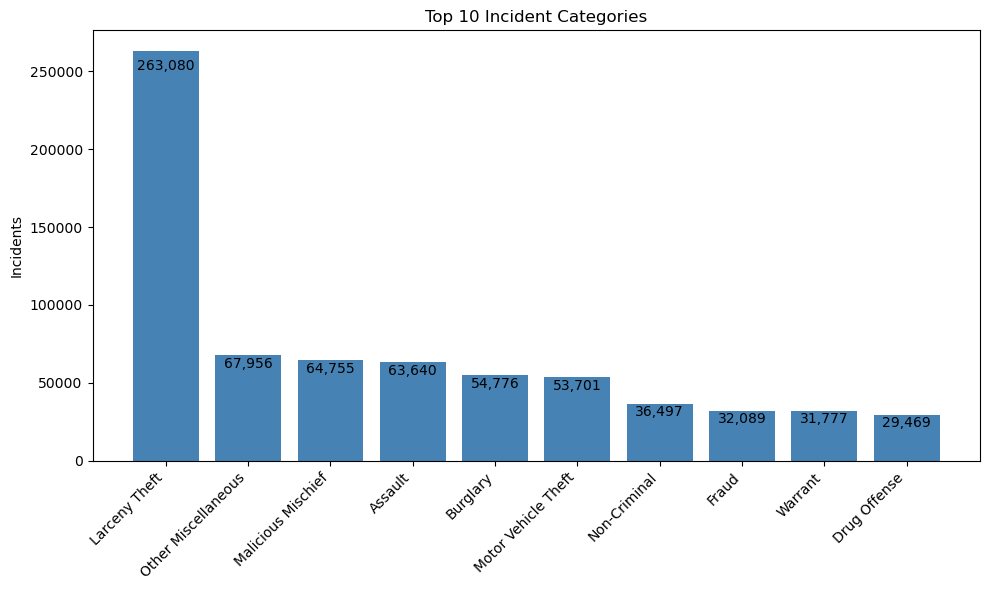

In [22]:
cat_counts = df["category"].value_counts().reset_index()
cat_counts.columns = ["category","incidents"]

display(cat_counts.head(15))

plt.figure(figsize=(10,6))
top10_cat = cat_counts.head(10)

bars = plt.bar(top10_cat["category"], top10_cat["incidents"], color="steelblue")

plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Incident Categories")
plt.ylabel("Incidents")

# ==== Add labels on top of bars (inside border) ====
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,   # center horizontally
        height * 0.98,                     # slightly below top border
        f"{int(height):,}",
        ha="center",
        va="top",
        fontsize=10,
        color="black"
    )

plt.tight_layout()
plt.show()


## 3.5 Hourly Pattern

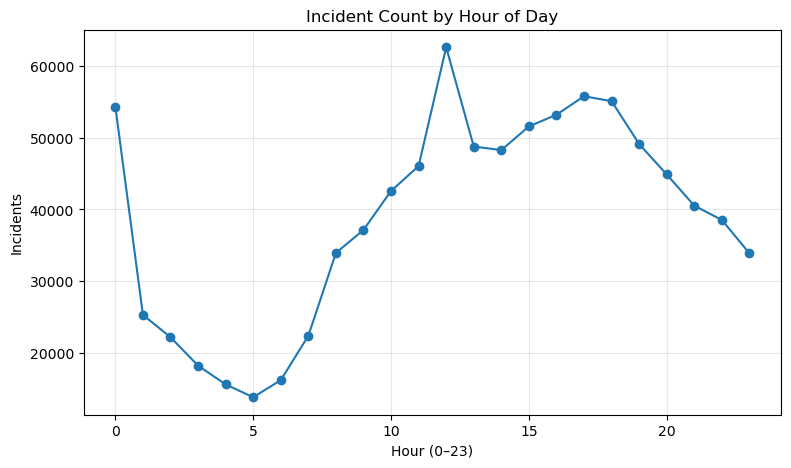

In [23]:
hour_counts = df["hour"].value_counts().sort_index()

plt.figure(figsize=(9,5))
plt.plot(hour_counts.index, hour_counts.values, marker="o")
plt.title("Incident Count by Hour of Day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Incidents")
plt.grid(True, alpha=0.3)
plt.show()


## 3.6 Weekday Pattern

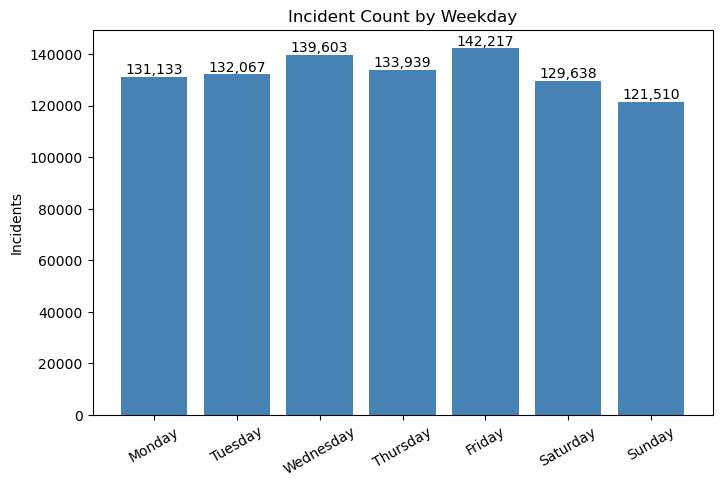

In [24]:
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
weekday_counts = df["weekday"].value_counts().reindex(weekday_order)

plt.figure(figsize=(8,5))
bars = plt.bar(weekday_counts.index, weekday_counts.values, color="steelblue")

plt.title("Incident Count by Weekday")
plt.ylabel("Incidents")
plt.xticks(rotation=30)

# === Add labels above bars ===
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,   # x-position (center of bar)
        height,                            # y-position (top of bar)
        f"{height:,}",                     # formatted label (comma-separated)
        ha="center", 
        va="bottom",
        fontsize=10
    )

plt.show()


## 3.7 Hour × Weekday Heatmap

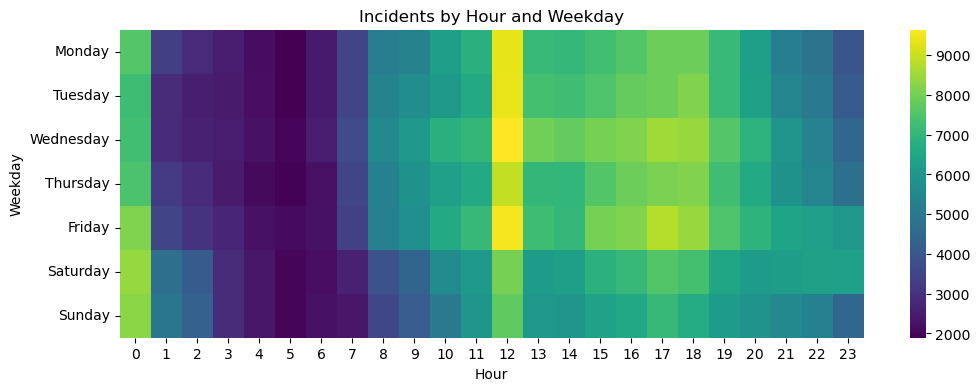

In [25]:
pivot_hw = df.pivot_table(index="weekday", columns="hour", values="Incident ID", aggfunc="count")
pivot_hw = pivot_hw.reindex(weekday_order)

plt.figure(figsize=(12,4))
sns.heatmap(pivot_hw, cmap="viridis")
plt.title("Incidents by Hour and Weekday")
plt.xlabel("Hour")
plt.ylabel("Weekday")
plt.show()


# 4. Neighborhood-Level Analysis
## 4.1 Ranking Neighborhoods

In [26]:
nbh_rank = df.groupby("neighborhood").size().sort_values(ascending=False)
display(nbh_rank.head(20))


neighborhood
Mission                           101396
Tenderloin                         98339
South of Market                    88102
Financial District/South Beach     63416
Bayview Hunters Point              59860
Western Addition                   32635
North Beach                        28706
Sunset/Parkside                    27773
Nob Hill                           26627
Marina                             26011
Castro/Upper Market                25847
Hayes Valley                       25757
Russian Hill                       21444
Bernal Heights                     20819
West of Twin Peaks                 18901
Outer Richmond                     18864
Mission Bay                        17739
Chinatown                          17435
Excelsior                          16798
Pacific Heights                    16721
dtype: int64

## 4.2 Neighborhood Time Series

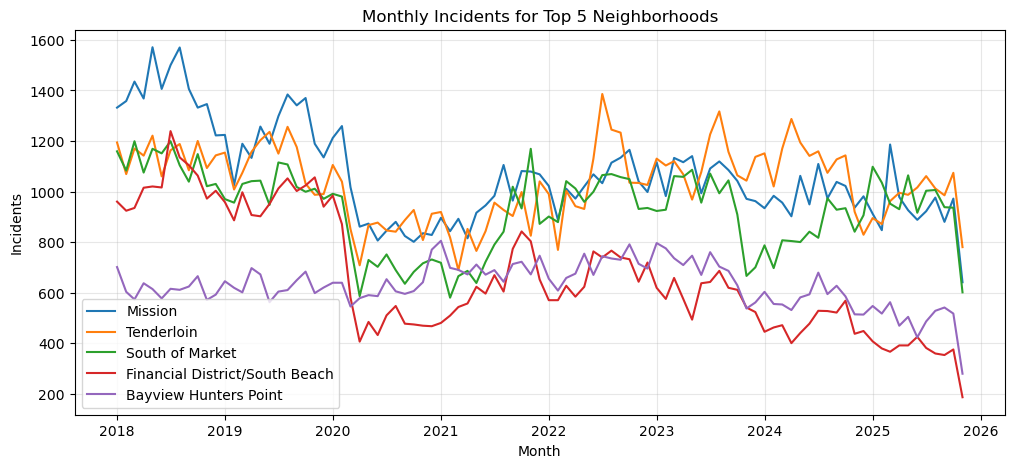

In [27]:
nbh_monthly = df.groupby(["month","neighborhood"]).size().reset_index(name="incidents")

top5 = nbh_rank.head(5).index.tolist()
top5_ts = nbh_monthly[nbh_monthly["neighborhood"].isin(top5)]

plt.figure(figsize=(12,5))
for n in top5:
    sub = top5_ts[top5_ts["neighborhood"] == n]
    plt.plot(sub["month"], sub["incidents"], label=n)

plt.title("Monthly Incidents for Top 5 Neighborhoods")
plt.xlabel("Month")
plt.ylabel("Incidents")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 4.3 Choropleth of Incidents by Analysis Neighborhood (41 zones)

In [29]:
# Step 1: Count incidents per neighborhood
nbh_counts = (
    df.groupby("neighborhood")
      .size()
      .reset_index(name="incident_count")
)

print("Top 10 neighborhoods by total incidents:\n")
display(
    nbh_counts.sort_values("incident_count", ascending=False)
              .head(10)
)

# Step 2: Join with boundary polygons
gdf_joined = gdf_nbh.merge(
    nbh_counts,
    left_on="nhood",
    right_on="neighborhood",
    how="left"
)

gdf_joined["incident_count"] = (
    gdf_joined["incident_count"]
    .fillna(0)
    .astype(int)
)

print(f"Neighborhood zones loaded: {len(gdf_joined)}")

# Step 3: Build Folium choropleth map
#import folium

m_choro = folium.Map(
    location=[37.77, -122.42],
    zoom_start=12.5,
    tiles="cartodbpositron"
)

folium.Choropleth(
    geo_data=gdf_joined,
    data=gdf_joined,
    columns=["nhood", "incident_count"],
    key_on="feature.properties.nhood",
    fill_color="YlOrRd",
    fill_opacity=0.75,
    line_opacity=0.7,
    legend_name="Total Incidents (2018–2025)",
    nan_fill_color="lightgray"
).add_to(m_choro)

folium.GeoJson(
    gdf_joined,
    name="Neighborhood Info",
    style_function=lambda x: {
        "fillColor": "#00000000",
        "color": "black",
        "weight": 0.6
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["nhood", "incident_count"],
        aliases=["Neighborhood:", "Incidents:"],
        sticky=True,
        localize=True
    )
).add_to(m_choro)

# Auto-zoom to SF bounds
bounds = gdf_joined.total_bounds
m_choro.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

folium.LayerControl().add_to(m_choro)

m_choro


Top 10 neighborhoods by total incidents:



,neighborhood,incident_count
18,Mission,101396
35,Tenderloin,98339
33,South of Market,88102
5,Financial District/South Beach,63416
0,Bayview Hunters Point,59860
40,Western Addition,32635
22,North Beach,28706
34,Sunset/Parkside,27773
20,Nob Hill,26627
16,Marina,26011


Neighborhood zones loaded: 41


# 5. Time-Series Forecasting (2026 Outlook)
## 5.1 Prepare Monthly Time Series

In [30]:
ts_monthly = df.groupby("month").size()
ts_monthly.index = pd.to_datetime(ts_monthly.index)

ts_monthly.head()


month
2018-01-01    12112
2018-02-01    10686
2018-03-01    11537
2018-04-01    11344
2018-05-01    11733
dtype: int64

## 5.2 Decomposition

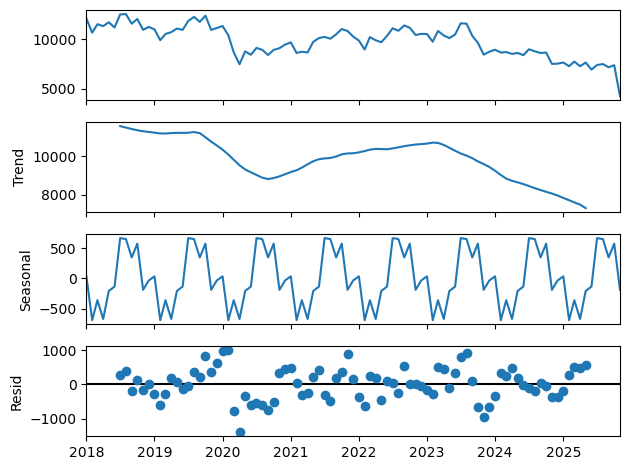

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(ts_monthly, model="additive", period=12)
decomp.plot()
plt.show()


## 5.3 Fit ARIMA Model

In [42]:
from statsmodels.tsa.arima.model import ARIMA


# Ensure monthly frequency is explicitly set
ts_monthly = ts_monthly.asfreq("MS")

print("Frequency:", ts_monthly.index.freq)

# Fit simple ARIMA(1,1,1)
model = ARIMA(ts_monthly, order=(1, 1, 1))
fit = model.fit()

print(fit.summary())


Frequency: <MonthBegin>
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   95
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -750.073
Date:                Sat, 22 Nov 2025   AIC                           1506.147
Time:                        05:11:04   BIC                           1513.777
Sample:                    01-01-2018   HQIC                          1509.229
                         - 11-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3964      0.511     -0.776      0.438      -1.397       0.605
ma.L1          0.1834      0.506      0.363      0.717      -0.808       1.175
sigma2      5.129e+05   5.01

**Insight:**
  
A baseline ARIMA(1,1,1) model was fitted to the monthly incident counts from 2018-2025. 
The frequency was set to “Month Start” to ensure consistent spacing. The AR and MA parameters were not statistically significant, indicating that monthly crime counts do not follow a strongly predictable autoregressive pattern. 

This aligns with the real-world expectation that crime can fluctuate due to many external factors such as events, economic shifts, policing initiatives, and seasonal variation. The Ljung–Box test (p = 0.71) indicates no remaining autocorrelation in the residuals, suggesting the model adequately captured the underlying structure. Residuals showed heavy tails, consistent with irregularly high-crime months. This ARIMA model provides a reasonable basis for short-term forecasting, although its predictive power is limited by the inherent variability of urban crime data.

In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Simple seasonal ARIMA baseline
model = SARIMAX(ts_monthly, order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit(disp=False)

print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   95
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -643.616
Date:                            Sat, 22 Nov 2025   AIC                           1297.232
Time:                                    05:11:30   BIC                           1309.266
Sample:                                01-01-2018   HQIC                          1302.064
                                     - 11-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4197      1.155     -0.363      0.716      -2.683       1.844
ma.L1          0.4978      1.106   

**Model note:** The SARIMAX fit produced near-singular covariance warnings, indicating unstable standard errors. Because the project goal is short-term forecasting and trend illustration (not coefficient inference), the forecast results are still used, while p-values are not emphasized.


## 5.4 Forecast Plot (early 2026)

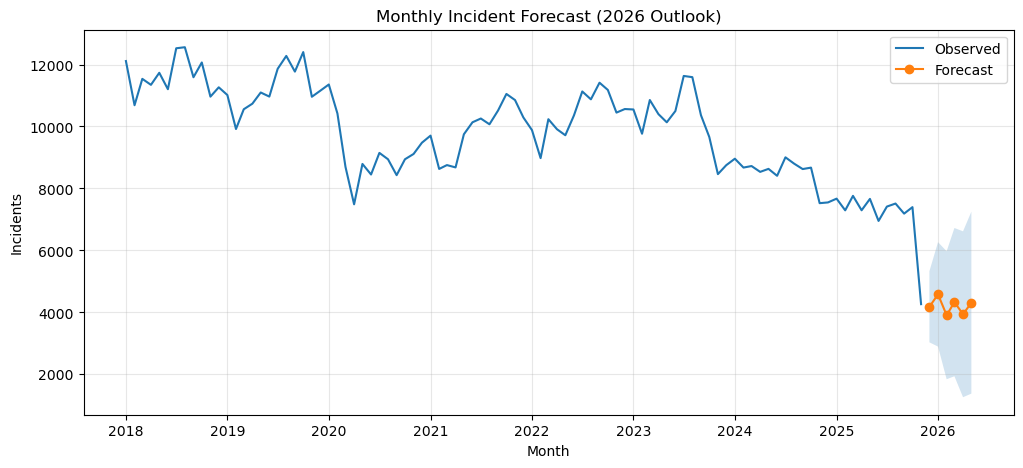

In [44]:
forecast_steps = 6  # first half-year of 2026
pred = results.get_forecast(steps=forecast_steps)
pred_ci = pred.conf_int()

forecast_index = pd.date_range(ts_monthly.index[-1] + pd.offsets.MonthBegin(1),
                              periods=forecast_steps, freq="MS")

plt.figure(figsize=(12,5))
plt.plot(ts_monthly, label="Observed")
plt.plot(forecast_index, pred.predicted_mean, label="Forecast", marker="o")
plt.fill_between(forecast_index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1],
                 alpha=0.2)

plt.title("Monthly Incident Forecast (2026 Outlook)")
plt.xlabel("Month")
plt.ylabel("Incidents")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 5.5 Summary Calculations for Forecast Interpretation

Before discussing the forecast insights, the following block computes the key numerical values needed for interpretation:

- **Average monthly incident count for 2025**  
- **Forecasted monthly incident totals for January–June 2026**  
- **Minimum and maximum forecasted values**  
- **Overall percent change from 2025 to the 2026 forecast window**

These values will support a clear transition into the final narrative analysis.



In [46]:
# ============================
# Summary values for interpreting forecast results
# ============================

print("==== Computing key values for interpretation ====\n")

# 1. Average monthly incidents in 2025
ts_2025 = ts_monthly[ts_monthly.index.year == 2025]
avg_2025 = ts_2025.mean()

print(f"Average monthly incidents in 2025: {avg_2025:.2f}\n")


# 2. Forecasted values for Jan–Jun 2026
forecast_values = pred.predicted_mean
print("Forecasted monthly incidents for Jan–Jun 2026:")
display(forecast_values)


# 3. Forecast range (min/max)
forecast_min = forecast_values.min()
forecast_max = forecast_values.max()

print(f"\nForecast range for first half of 2026: {forecast_min:.2f} – {forecast_max:.2f}\n")


# 4. Percent change from 2025 average
percent_change = ((forecast_values.mean() - avg_2025) / avg_2025) * 100
print(f"Percent change from 2025 average: {percent_change:.2f}%\n")


==== Computing key values for interpretation ====

Average monthly incidents in 2025: 7128.73

Forecasted monthly incidents for Jan–Jun 2026:


2025-12-01    4181.645288
2026-01-01    4581.756002
2026-02-01    3908.242929
2026-03-01    4331.506615
2026-04-01    3939.697580
2026-05-01    4314.564329
Freq: MS, Name: predicted_mean, dtype: float64


Forecast range for first half of 2026: 3908.24 – 4581.76

Percent change from 2025 average: -40.95%



## 6. Results and Interpretation

This section summarizes the key findings from the exploratory analysis and the forecasting of San Francisco Police Department incident data (2018–2025). Together, these results describe how crime patterns vary across time, neighborhood, and incident type, and how they are expected to evolve into early 2026.

---

### 6.1 Exploratory Findings (2018–2025)

#### **1. Long-Term Yearly Trend**
Citywide incident volume shows a multi-year decline beginning after the COVID-19 pandemic. Incidents rose between 2021 and 2023 but did not return to pre-2020 levels. The decline continued through 2024 and 2025, reflecting permanent shifts in mobility: hybrid work, reduced office density, and changes in tourism.

#### **2. Neighborhood Hotspots**
The highest-volume neighborhoods from 2018–2025 were:

- **Mission (101,396 incidents)**
- **Tenderloin (98,339 incidents)**
- **South of Market (88,102 incidents)**
- **Financial District/South Beach (63,416 incidents)**
- **Bayview Hunters Point (59,860 incidents)**

These areas remain the core activity zones of the city due to their dense commercial presence, transit corridors, nightlife, and complex challenges involving homelessness and drug markets.

#### **3. Dominant Incident Categories**
A few categories account for most reported incidents:

- **Larceny Theft** (263,080) — the dominant category
- **Other Miscellaneous**, **Malicious Mischief**, **Assault**
- **Motor Vehicle Theft** and **Burglary**

These patterns align with long-standing concerns involving property crime and opportunistic theft.

#### **4. Time-of-Day and Weekday Patterns**
Incident timing follows predictable cycles:

- Highest activity occurs **midday through early evening**, peaking around **12 PM**.
- A second plateau extends from **3 PM to 7 PM**.
- **Fridays** and **Wednesdays** have the highest incident counts; **Sundays** the lowest.

These reflect daily foot-traffic patterns, nightlife, workplace rhythms, and transit flow.

---

### 6.2 Forecast Interpretation (2026 Outlook)

#### **Forecast Summary**

A seasonal ARIMA model indicates that San Francisco is expected to record **3,900–4,600 incidents per month** during the first half of 2026. This is a substantial decline from the 2025 monthly average of **7,129 incidents**, representing a **40.95% decrease**.

This projection reinforces the downward trend seen in recent years.

---

#### **Comparison: 2025 vs. 2026 Forecast**

| Year | Metric | Value |
|------|--------|--------|
| **2025** | Average monthly incidents | **7,129** |
| **2026 (Jan–Jun)** | Forecasted monthly incidents | **3,908 – 4,582** |
| **Change** | Percent difference | **−40.95%** |

**Key takeaway:**  
Incident volume in early 2026 is expected to remain far below 2025 levels.

---

#### **Interpretation in Real-World Context**

Several factors help explain this projected decline:

- **Hybrid/remote work** continues to reduce foot traffic in SoMa, the Financial District, and downtown corridors.
- **Tourism patterns** have shifted post-pandemic, affecting mid-day and early evening activity.
- **Public safety initiatives** introduced in early 2025 aim to stabilize high-activity zones.

Mayor Daniel Lurie’s **Rebuilding the Ranks** plan and **Breaking the Cycle** directive emphasize:

- expanding sworn police staffing  
- coordinated strategies for the fentanyl and addiction crisis  
- enhanced communication among law-enforcement agencies  

These public-policy changes, combined with long-term mobility shifts, provide context for the declining forecasted incident levels.

**Source:**  
SF.gov – “Mayor Lurie Takes Major Step Forward for San Francisco Safety, Announces Rebuilding the Ranks Roadmap”  
https://www.sf.gov/news-mayor-lurie-takes-major-step-forward-for-san-francisco-safety-announces-rebuilding-the-ranks-roadmap-to-fully-staff-police-department-sheriffs-office

---

### 6.3 Implications for Neighborhoods and Resource Planning

#### **1. Targeted Resource Allocation**
Despite lower overall volume, the Tenderloin, South of Market, Financial District/South Beach, and Mission remain high-activity nodes requiring focused patrols and hotspot monitoring.

#### **2. Seasonal Staffing Optimization**
Seasonal patterns remain visible; forecasting enables more efficient deployment across the year.

#### **3. Quality-of-Life Considerations**
Lower total incidents do not eliminate concerns regarding theft, vandalism, and vehicle-related crime, especially in tourist and nightlife corridors.

#### **4. Visitor and Resident Guidance**
Data-driven insights help visitors make informed hotel choices and support residents seeking realistic safety expectations.

#### **5. Operational Stability for SFPD**
Short-term forecasts support workload planning, reporting expectations, and equitable resource distribution across police districts.

---

### **Overall Interpretation**

San Francisco’s trends highlight a city adapting to long-term structural change. While neighborhood-level hotspots persist, the broader citywide volume of incidents has declined substantially. Predictable temporal patterns and a strong downward forecast support data-driven policing strategies and improved communication for residents, workers, and visitors navigating the city.


---

# 7. Streamlit Mini-Dashboard

Having completed the exploratory analysis, spatial mapping, and 2026 forecasting, the next step is to translate these insights into an interactive format. While the official SFPD Crime Dashboard offers high-level summaries, it does not provide neighborhood-level granularity, time-series exploration, or predictive modeling. To address these gaps, I now develop a Streamlit mini-dashboard that allows users to explore incidents across the 41 Analysis Neighborhoods, examine temporal patterns, and interact directly with the forecast results.

---


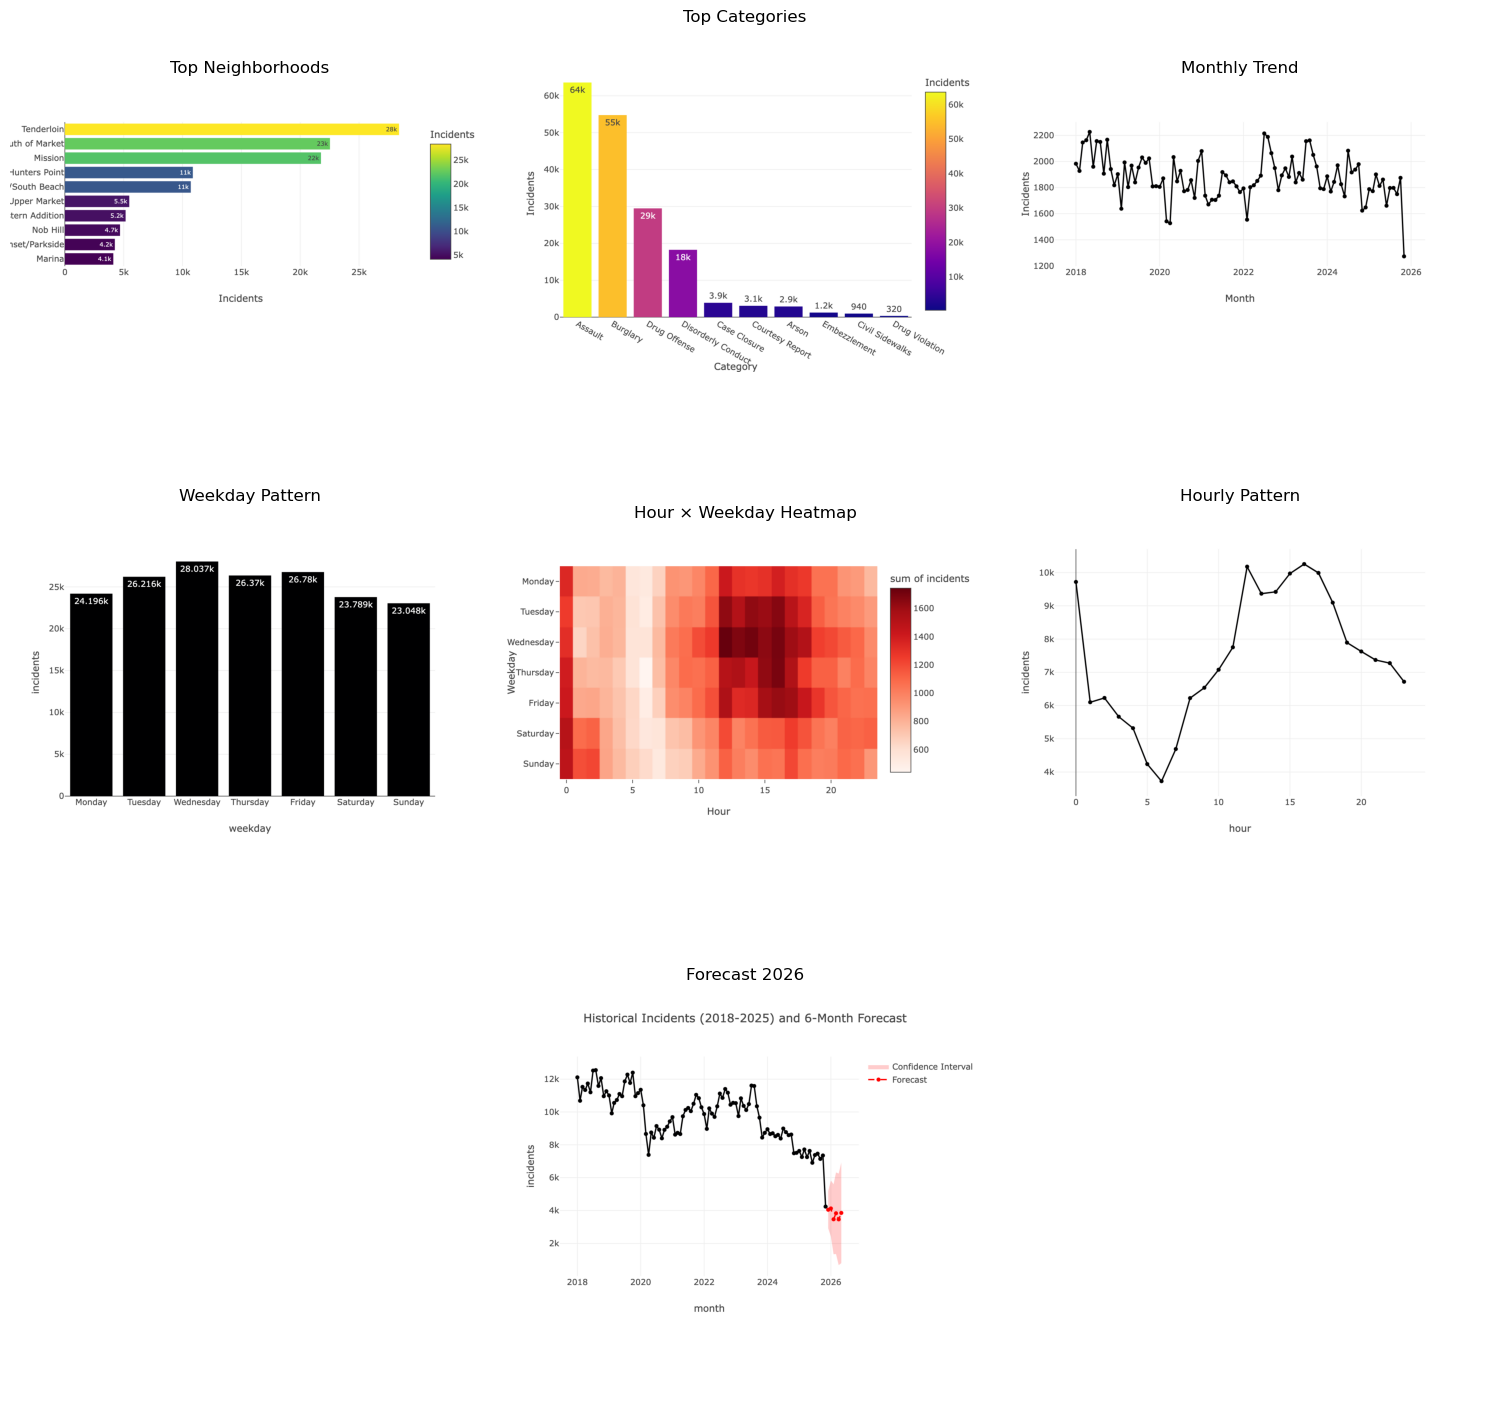

In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

# Folder containing downloaded charts
chart_dir = Path("/Users/sileshihirpa/Desktop/ASU/2025/3. Fall/Session B/DAT301/Projects/project 2/dashboard_charts")

# Explicit manual mapping (adjust names if needed)
chart_files = {
    "Top Neighborhoods": "top_neighborhoods.png",
    "Top Categories": "top_categories.png",
    "Monthly Trend": "monthly_trend.png",
    
    "Weekday Pattern": "weekday_pattern.png",
    "Hour × Weekday Heatmap": "hour_weekday_heatmap.png",
    "Hourly Pattern": "hourly_pattern.png",
    
    "Forecast 2026": "forecast_2026.png"
}

# --- Create the grid ---
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# --- Top row ---
top_row = ["Top Neighborhoods", "Top Categories", "Monthly Trend"]

for col, title in enumerate(top_row):
    img = mpimg.imread(chart_dir / chart_files[title])
    axes[0, col].imshow(img)
    axes[0, col].set_title(title, fontsize=12)
    axes[0, col].axis("off")

# --- Middle row ---
middle_row = ["Weekday Pattern", "Hour × Weekday Heatmap", "Hourly Pattern"]

for col, title in enumerate(middle_row):
    img = mpimg.imread(chart_dir / chart_files[title])
    axes[1, col].imshow(img)
    axes[1, col].set_title(title, fontsize=12)
    axes[1, col].axis("off")

# --- Bottom row (centered across 3 columns) ---
img = mpimg.imread(chart_dir / chart_files["Forecast 2026"])

# Use only the middle column for the bottom row
axes[2, 0].axis("off")
axes[2, 2].axis("off")

axes[2, 1].imshow(img)
axes[2, 1].set_title("Forecast 2026", fontsize=12)
axes[2, 1].axis("off")

plt.tight_layout()
plt.show()


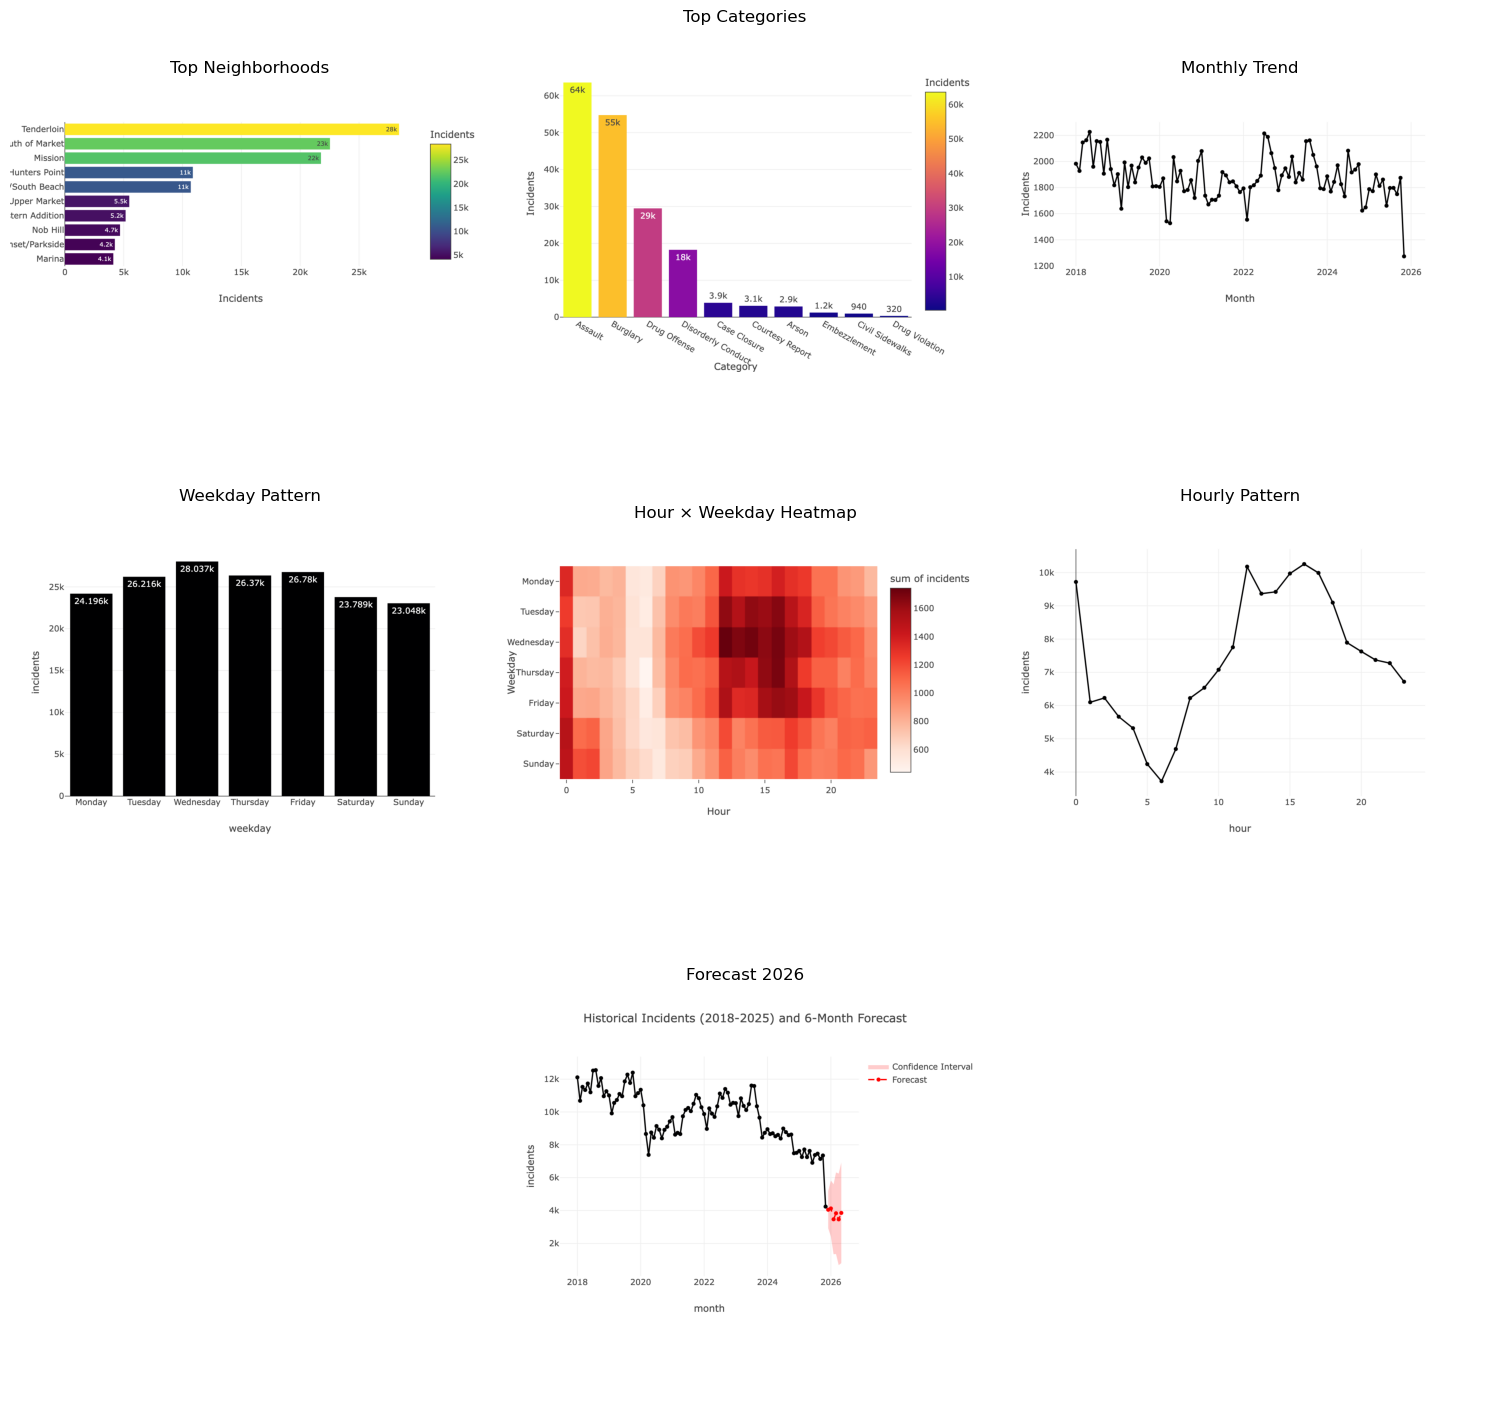

Saved grid to: /Users/sileshihirpa/Desktop/ASU/2025/3. Fall/Session B/DAT301/Projects/project 2/dashboard_charts/dashboard_grid.png


In [53]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

# Folder containing downloaded charts
chart_dir = Path("/Users/sileshihirpa/Desktop/ASU/2025/3. Fall/Session B/DAT301/Projects/project 2/dashboard_charts")

# Explicit manual mapping
chart_files = {
    "Top Neighborhoods": "top_neighborhoods.png",
    "Top Categories": "top_categories.png",
    "Monthly Trend": "monthly_trend.png",
    "Weekday Pattern": "weekday_pattern.png",
    "Hour × Weekday Heatmap": "hour_weekday_heatmap.png",
    "Hourly Pattern": "hourly_pattern.png",
    "Forecast 2026": "forecast_2026.png"
}

# Output file
out_path = chart_dir / "dashboard_grid.png"

# --- Create grid ---
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Top row
top_row = ["Top Neighborhoods", "Top Categories", "Monthly Trend"]
for col, title in enumerate(top_row):
    img = mpimg.imread(chart_dir / chart_files[title])
    axes[0, col].imshow(img)
    axes[0, col].set_title(title, fontsize=12)
    axes[0, col].axis("off")

# Middle row
middle_row = ["Weekday Pattern", "Hour × Weekday Heatmap", "Hourly Pattern"]
for col, title in enumerate(middle_row):
    img = mpimg.imread(chart_dir / chart_files[title])
    axes[1, col].imshow(img)
    axes[1, col].set_title(title, fontsize=12)
    axes[1, col].axis("off")

# Bottom row centered
img = mpimg.imread(chart_dir / chart_files["Forecast 2026"])
axes[2, 0].axis("off")
axes[2, 2].axis("off")

axes[2, 1].imshow(img)
axes[2, 1].set_title("Forecast 2026", fontsize=12)
axes[2, 1].axis("off")

plt.tight_layout()

# Save AND show
fig.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved grid to:", out_path)
